In [1]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, printDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleRegular, emitParticlesRegular, emitParticlesSDF
from diffSPH.v2.math import volumeToSupport
from diffSPH.v2.modules.neighborhood import fluidNeighborSearch
from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.sphOps import sphOperationFluidState
from torchCompactRadius.util import countUniqueEntries
from diffSPH.v2.plotting import scatterPlotFluid, scatterPlotFluidSymmetric, plotImplicitSDF
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne
from diffSPH.v2.modules.surfaceDetection import computeColorField, computeColorFieldGradient
from diffSPH.v2.modules.surfaceDetection import detectFreeSurfaceColorField, detectFreeSurfaceColorFieldGradient
from diffSPH.v2.modules.surfaceDetection import detectFreeSurfaceBarecasco
from diffSPH.v2.modules.surfaceDetection import computeSurfaceDistance, getStableSurfaceNormal
import matplotlib.pyplot as plt
import torch
import numpy as np
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict

In [2]:
from diffSPH.v2.plotting import *

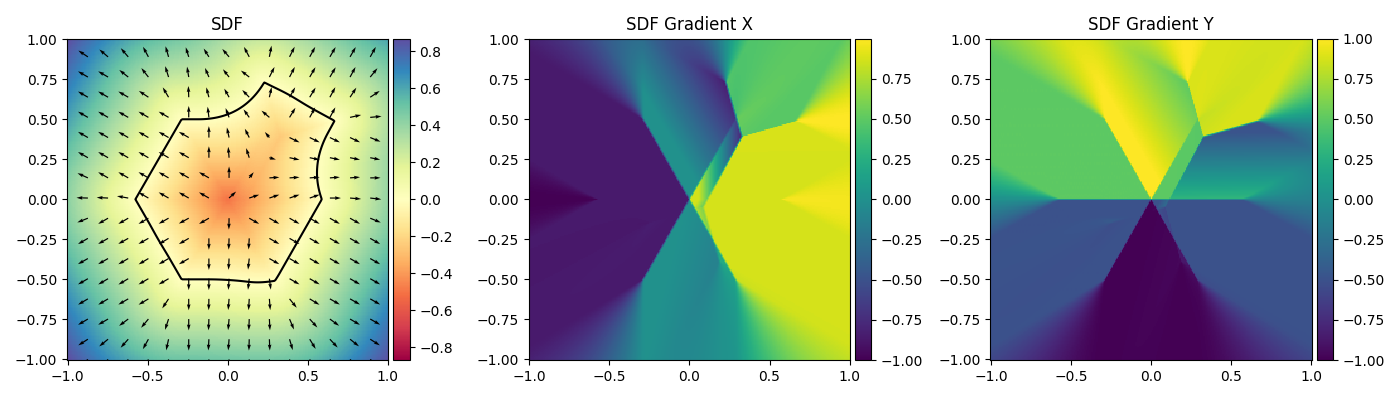

In [3]:


ngrid = 255
x = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
y = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('hexagon')['function'](points, 0.5)
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([0.25,0.5]))
translated = operatorDict['translate'](sphere_b, torch.tensor([0.1,0.25]))
rotated = operatorDict['rotate'](translated, 0.5)
sdf = operatorDict['smooth_union'](rotated, sphere_a, 0.25)

# circle_a = operatorDict['translate'](lambda points: getSDF('hexagon')['function'](points, 0.35), torch.tensor([-0.25,0.]))
# circle_b = operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.35), torch.tensor([ 0.25,0.]))
# sdf = operatorDict['smooth_union'](circle_a, circle_b, 0.05)
# sdf = operatorDict['twist'](sdf, 0.5)
# sdf = operatorDict['shell'](sdf, 0.125)
# sdf = sphere_a
plotSDF(sdf(torch.clone(points),), X, Y, 2, 2)

In [4]:
config = {
    'domain': {
        'minExtent': -1,
        'maxExtent': 1,
        'dim': 2,
        'periodic': True
    },
    'particle': {
        'nx': 64
    },
    'kernel':{
        'name': 'Wendland2'
    },
    "neighborhood":{
        "scheme": "compact"
    },
    'EOS':{
        'type': 'Tait',
        'kappa': 1.5
    }
}

config = parseDefaultParameters(config)
config = parseModuleParameters(config)

display(config)

{'domain': {'minExtent': tensor([-1., -1.]),
  'maxExtent': tensor([1., 1.]),
  'dim': 2,
  'periodic': True,
  'periodicity': tensor([True, True])},
 'particle': {'nx': 64,
  'dx': tensor(0.0312),
  'defaultVolume': tensor(0.0010),
  'defaultSupport': 0.12466946262544772,
  'volume': tensor(0.0010),
  'support': 0.12466946262544772},
 'kernel': {'name': 'Wendland2',
  'targetNeighbors': 50,
  'function': <diffSPH.kernels.KernelWrapper at 0x7f32fc70a080>},
 'neighborhood': {'scheme': 'compact'},
 'EOS': {'type': 'Tait',
  'kappa': 1.5,
  'gasConstant': 8.14,
  'molarMass': 0.02897,
  'polytropicExponent': 7},
 'compute': {'device': 'cpu', 'precision': 'float32', 'dtype': torch.float32},
 'simulation': {'correctArea': False, 'supportScheme': 'symmetric'},
 'fluid': {'rho0': 2000, 'mu': 0.1, 'cs': 10},
 'integration': {'dt': 0.01,
  'adaptiveTimestep': False,
  'CFL': 0.25,
  'maxDt': 0.1,
  'minDt': 0.001,
  'scheme': 'semiImplicitEuler'},
 'surfaceDetection': {'colorFieldGradientThresh

In [5]:
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict
from diffSPH.v2.sampling import filterParticlesWithSDF

particlesA, volumeA = sampleRegular(config['particle']['dx'], config['domain']['dim'], config['domain']['minExtent'], config['domain']['maxExtent'], config['kernel']['targetNeighbors'], config['simulation']['correctArea'], config['kernel']['function'])


# areasA = particlesA.new_ones(particlesA.shape[0]) * volumeA
# onesA = particlesA.new_ones(particlesA.shape[0])
# supportsA = particlesA.new_ones(particlesA.shape[0]) * h

factor = 1
# particlesB, volumeB = sampleRegular(dx / factor, dim, minExtent, domainMax, targetNeighbors, True, k)
# hB = volumeToSupport(volumeB, targetNeighbors, dim)
# areasB = particlesB.new_ones(particlesB.shape[0]) * volumeA
# onesB = particlesB.new_ones(particlesB.shape[0])
# supportsB = particlesB.new_ones(particlesB.shape[0]) * h
h = volumeToSupport(volumeA, config['kernel']['targetNeighbors'], config['domain']['dim'])

maskedA, maskA, *_ = filterParticlesWithSDF(particlesA, operatorDict['invert'](sdf), h, -1e-4)

In [6]:
print(particlesA.shape)
print(maskA.shape)

torch.Size([4096, 2])
torch.Size([4096])


In [7]:
coarseParticles = particlesA[maskA]
fineParticles = particlesA[~maskA]
print(fineParticles.shape)
refinedParticles = []
dx = config['particle']['dx']
offsets = torch.tensor([[-dx / 4, -dx / 4], [-dx / 4, dx / 4], [dx / 4,-dx / 4], [dx / 4,dx / 4]], dtype = torch.float32)
for offset in offsets:
    print(offset)
    refinedParticles.append(fineParticles + offset.view(-1,2))
fineParticles = torch.cat(refinedParticles, dim = 0)



torch.Size([1056, 2])
tensor([-0.0078, -0.0078])
tensor([-0.0078,  0.0078])
tensor([ 0.0078, -0.0078])
tensor([0.0078, 0.0078])


In [8]:
fineParticles.shape

torch.Size([4224, 2])

(<matplotlib.collections.PathCollection at 0x7f32fc617070>,
 <matplotlib.colorbar.Colorbar at 0x7f32fc65c220>)

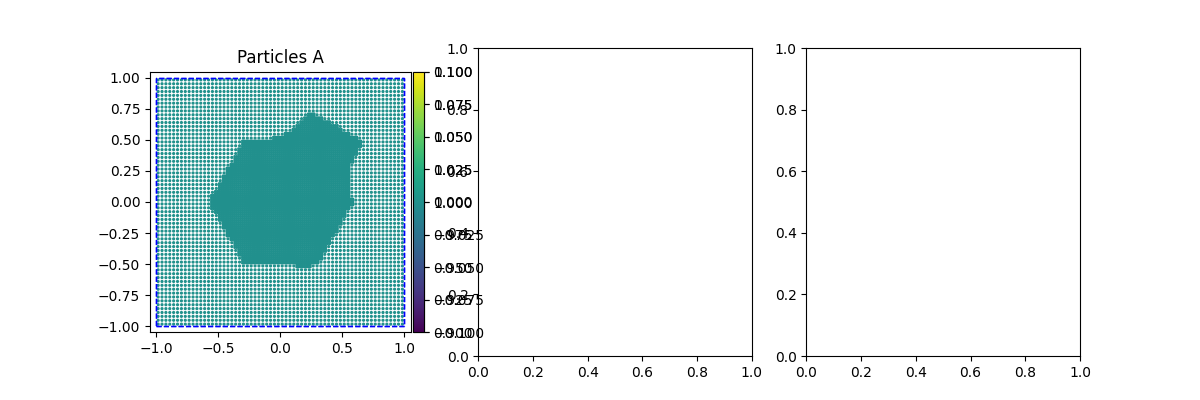

In [9]:
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
scatterPlot(fig, axis[0,0], coarseParticles, torch.zeros(coarseParticles.shape[0]), config['domain']['minExtent'], config['domain']['maxExtent'], 'Particles A')
scatterPlot(fig, axis[0,0], fineParticles, torch.ones(fineParticles.shape[0]), config['domain']['minExtent'], config['domain']['maxExtent'], 'Particles A')

In [10]:
particles = torch.cat([coarseParticles, fineParticles], dim = 0)
import copy

perennialState = {}

area = (4 / config['particle']['nx']**2)
perennialState['fluidPositions'] = particles
perennialState['fluidAreas'] = particles.new_ones(particles.shape[0]) * 2 * area
perennialState['fluidMasses'] = perennialState['fluidAreas'] * config['fluid']['rho0']
perennialState['fluidSupports'] = volumeToSupport(area, config['kernel']['targetNeighbors'], config['domain']['dim'])
perennialState['fluidVelocities'] = torch.zeros_like(particles)

perennialState['numParticles'] = particles.shape[0]

perennialState['fluidNeighborhood'] = fluidNeighborSearch(perennialState, config)
perennialState['fluidDensities'] = sphOperationFluidState(perennialState, None, 'density')
_, perennialState['fluidNumNeighbors'] = countUniqueEntries(perennialState['fluidNeighborhood']['indices'][0], perennialState['fluidPositions'])

initialState = copy.deepcopy(perennialState)
config['fluid']['mu'] = 0.05
config['integration']['scheme'] = 'semiImplicitEuler'

In [11]:
from diffSPH.v2.modules.pressureEOS import computeEOS
from diffSPH.v2.modules.pressureForce import computePressureAccel
from diffSPH.v2.modules.viscosity import computeViscosityMonaghan


def simulationStep(simulationState, config):
    simulationState['fluidNeighborhood'] = fluidNeighborSearch(simulationState, config)
    simulationState['fluidDensities'] = sphOperationFluidState(simulationState, None, 'density')

    simulationState['fluidPressures'] = computeEOS(simulationState, config)
    # simulationState['fluidPressures'] = 1.5 * (simulationState['fluidDensities'] - config['fluid']['rho0'])
    simulationState['fluidPressureAccel'] = computePressureAccel(simulationState, config) #sphOperationFluidState(simulationState, (simulationState['fluidPressures'], simulationState['fluidPressures']), operation = 'gradient', gradientMode='symmetric') / simulationState['fluidDensities'].view(-1,1) #computePressureForce(simulationState, config)
    simulationState['fluidViscosityAccel'] = computeViscosityMonaghan(simulationState, config)

    dudt = simulationState['fluidPressureAccel'] + simulationState['fluidViscosityAccel']# * simulationState['fluidDensities'].view(-1,1)

    return dudt

In [12]:

def initPlot(perennialState):
    fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
    scDensity, cbarDensity = scatterPlotFluid(fig, axis[0,0], perennialState, config, perennialState['fluidDensities'], 'Density')
    scVelocity_x, cbarVelocity_x = scatterPlotFluidSymmetric(fig, axis[0,1], perennialState, config, perennialState['fluidVelocities'][:,0], 'Velocity.x', cmap = 'Spectral')
    scVelocity_y, cbarVelocity_y = scatterPlotFluidSymmetric(fig, axis[0,2], perennialState, config, perennialState['fluidVelocities'][:,1], 'Velocity.y', cmap = 'Spectral')
    fig.tight_layout()

    return fig, axis, scDensity, cbarDensity, scVelocity_x, cbarVelocity_x, scVelocity_y, cbarVelocity_y

def updatePlot(perennialState, scDensity, cbarDensity, scVelocity_x, cbarVelocity_x, scVelocity_y, cbarVelocity_y):
    p = perennialState['fluidPositions']
    periodicPositions = torch.stack([p[:,i] if not periodic else torch.remainder(p[:,i] - config['domain']['minExtent'][i], config['domain']['maxExtent'][i] - config['domain']['minExtent'][i]) + config['domain']['minExtent'][i] for i, periodic in enumerate(config['domain']['periodicity'])], dim = 1)

    c = perennialState['fluidDensities']
    scDensity.set_offsets(periodicPositions)
    scDensity.set_array(c)
    scDensity.set_clim(vmin = torch.abs(c).min().item(), vmax = torch.abs(c).max().item())
    cbarDensity.update_normal(scDensity)


    c = perennialState['fluidVelocities'][:,0]
    scVelocity_x.set_offsets(periodicPositions)
    scVelocity_x.set_array(perennialState['fluidVelocities'][:,0])
    scVelocity_x.set_clim(vmin = torch.abs(c).max().item() * -1, vmax = torch.abs(c).max().item())
    cbarVelocity_x.update_normal(scVelocity_x)

    c = perennialState['fluidVelocities'][:,1]
    scVelocity_y.set_offsets(periodicPositions)
    scVelocity_y.set_array(c)
    scVelocity_y.set_clim(vmin = torch.abs(c).max().item() * -1, vmax = torch.abs(c).max().item())
    cbarVelocity_y.update_normal(scVelocity_y)

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.autonotebook import tqdm
import copy

dudt = None

import matplotlib.pyplot as plt
import matplotlib.colors as colors

norm = colors.Normalize(vmin=0, vmax=2048)
cmap = plt.cm.get_cmap('viridis')

perennialState = copy.deepcopy(initialState)

simulationStates = []
perennialState, dudt = integrate(simulationStep, perennialState, config, previousStep= dudt)

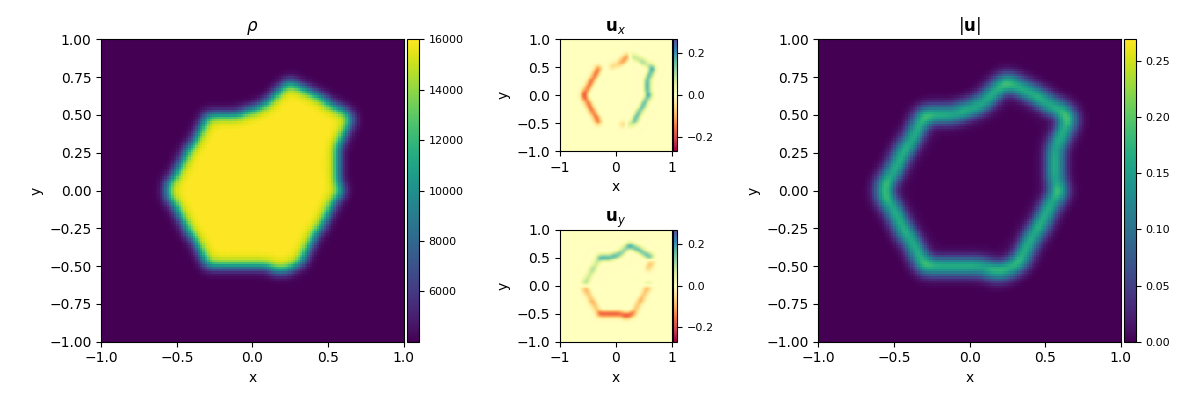

In [21]:
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

fig, axis = plt.subplot_mosaic('''AABCC
                               AADCC''', figsize=(12,4), sharex = False, sharey = False)

# fig, axis = plt.subplots(1, 2, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

visualizationState = prepVisualizationState(perennialState, config)
plotStateDensity = visualizeParticles(fig, axis['A'], config, visualizationState, perennialState['fluidDensities'], cbar = True, cmap = 'viridis', scaling = 'lin', midPoint = 0, gridVisualization= True)
axis['A'].set_title('$\\rho$')
plotStateA = visualizeParticles(fig, axis['B'], config, visualizationState, perennialState['fluidVelocities'], mapping = '.x', cbar = True, cmap = 'Spectral', scaling = 'sym', midPoint = 0, gridVisualization= True)
axis['B'].set_title('$\\mathbf{u}_x$')
plotStateB = visualizeParticles(fig, axis['D'], config, visualizationState, perennialState['fluidVelocities'], mapping = '.y', cbar = True, cmap = 'Spectral', scaling = 'sym', midPoint = 0, gridVisualization= True)
axis['D'].set_title('$\\mathbf{u}_y$')
plotStateVelocityNorm = visualizeParticles(fig, axis['C'], config, visualizationState, perennialState['fluidVelocities'], mapping = 'L2', cbar = True, cmap = 'viridis', scaling = 'lin', midPoint = 0, gridVisualization= True)
axis['C'].set_title('$|\\mathbf{u}|$')
fig.tight_layout()

In [22]:
for i in tqdm(range(512)):
    perennialState, dudt = integrate(simulationStep, perennialState, config, previousStep= dudt)

    # simulationStates.append(copy.deepcopy(perennialState))


    if i % 32 == 0 and i > 0:
        visualizationState = prepVisualizationState(perennialState, config)
        updatePlot(plotStateDensity, visualizationState, perennialState['fluidDensities'])
        updatePlot(plotStateA, visualizationState, perennialState['fluidVelocities'])
        updatePlot(plotStateB, visualizationState, perennialState['fluidVelocities'])
        updatePlot(plotStateVelocityNorm, visualizationState, perennialState['fluidVelocities'])
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        # break
    # break

  0%|          | 0/512 [00:00<?, ?it/s]

In [171]:
visualization = {
    'quantity': 'fluidDensities',
    'cmap': 'Spectral',
    'norm': 'linear',
    'vmin': 0,
    'vmax': 2048,
    'updateScale': True,
    'particleOp': 'None',
    'visualization': 'scatter',
}

velocityVisualization = {
    'quantity': 'fluidVelocities',
    'cmap': 'Spectral',
    'norm': 'linear',
    'vmin': 0,
    'vmax': 2048,
    'updateScale': True,
    'particleOp': 'None',
    'visualization': 'grid',
    'gridOp': 'divergence',
    'vectorMode': ['components', 'magnitude', 'quiver']
}

In [172]:
def getPlotSpec(visualization, state, config):
    simulationDim = state['fluidPositions'].shape[1]
    print(simulationDim)
    quantity = state[visualization['quantity']]
    quantityDim = [] if quantity.ndim == 1 else list(quantity.shape[1:])
    print(quantityDim)

    if visualization['particleOp'] == 'gradient':
        quantityDim = quantityDim + [simulationDim]
    if visualization['particleOp'] == 'laplacian':
        quantityDim = quantityDim
    if visualization['particleOp'] == 'divergence':
        quantityDim = quantityDim[:-1]
    if 'gridOp' in visualization:
        if visualization['gridOp'] == 'gradient':
            quantityDim = quantityDim + [simulationDim]
        if visualization['gridOp'] == 'laplacian':
            quantityDim = quantityDim
        if visualization['gridOp'] == 'divergence':
            quantityDim = quantityDim[:-1]
    print(quantityDim)
    if quantityDim == [simulationDim]: # vector field
        print('vector')
        vectorModes = visualization['vectorMode']
        if 'components' in vectorModes and 'magnitude' in vectorModes and 'quiver' in vectorModes:
            return [2,3]
        if 'components' in vectorModes and 'magnitude' in vectorModes:
            return [2,2]
        if 'components' in vectorModes and 'quiver' in vectorModes:
            return [2,2]
        if 'magnitude' in vectorModes and 'quiver' in vectorModes:
            return [1,1]
        if 'components' in vectorModes:
            return [1,2]
        if 'magnitude' in vectorModes:
            return [1,1]
        if 'quiver' in vectorModes:
            return [1,1]
    elif quantityDim == []: # scalar field
        print('scalar')
        return [1,1]
    elif quantityDim == [simulationDim, simulationDim]: # tensor field
        print('tensor')
        return [simulationDim, simulationDim]
    else:
        raise ValueError('Invalid quantity dimension')


print('a')
getPlotSpec(visualization, perennialState, config)
print('b')
getPlotSpec(velocityVisualization, perennialState, config)

a
2
[]
[]
scalar
b
2
[2]
[]
scalar


[1, 1]

In [173]:
densitySpec = getPlotSpec(visualization, perennialState, config)
velocitySpec = getPlotSpec(velocityVisualization, perennialState, config)

nrows = max(densitySpec[0], velocitySpec[0])
ncols = densitySpec[1] + velocitySpec[1]

print(nrows, ncols)

2
[]
[]
scalar
2
[2]
[]
scalar
1 2


In [293]:
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.kernels import getKernel

In [294]:
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

In [295]:
print(P.shape, perennialState['numParticles'])
print(i.max(), j.max())

torch.Size([16384, 2]) 7264
tensor(16383) tensor(7263)


In [305]:
visualizationState = prepVisualizationState(perennialState, config)

gridDensity = mapToGrid(visualizationState, perennialState, perennialState['fluidDensities'])

torch.Size([7264])
torch.Size([7264])


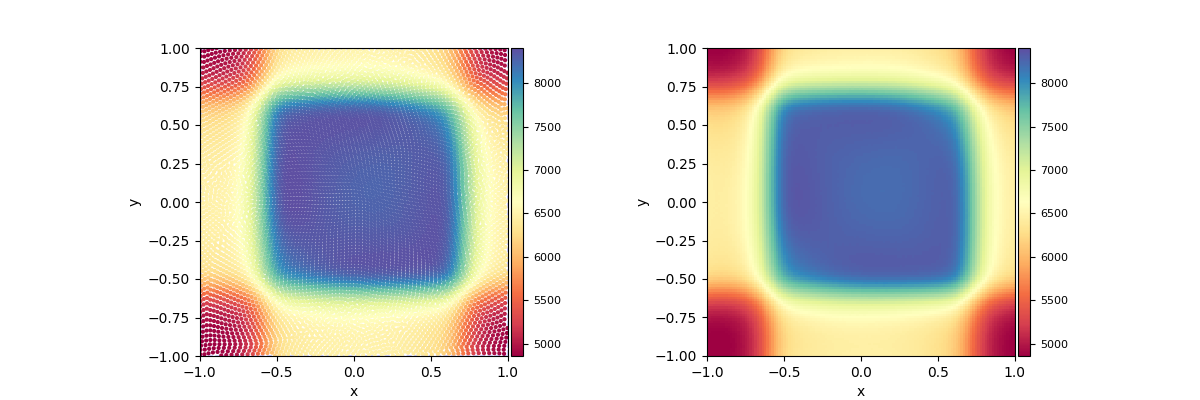

In [306]:
fig, axis = plt.subplots(1, 2, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

plotStateA = visualizeParticles(fig, axis[0,0], visualizationState, perennialState['fluidDensities'], mapping = None, cbar = True, cmap = visualization['cmap'], scaling = visualization['norm'])

plotStateB = visualizeParticles(fig, axis[0,1], visualizationState, perennialState['fluidDensities'], mapping = None, cbar = True, cmap = visualization['cmap'], scaling = visualization['norm'], gridVisualization= True)


In [307]:
# updatePlot(plotStateA, fig, axis[0,0], visualizationState, perennialState['fluidVelocities'][:,0])
updatePlot(plotStateB, fig, axis[0,1], visualizationState, perennialState['fluidVelocities'][:,1])

torch.Size([7264])


torch.Size([7264, 2])
torch.Size([7264, 2])
torch.Size([7264, 2])


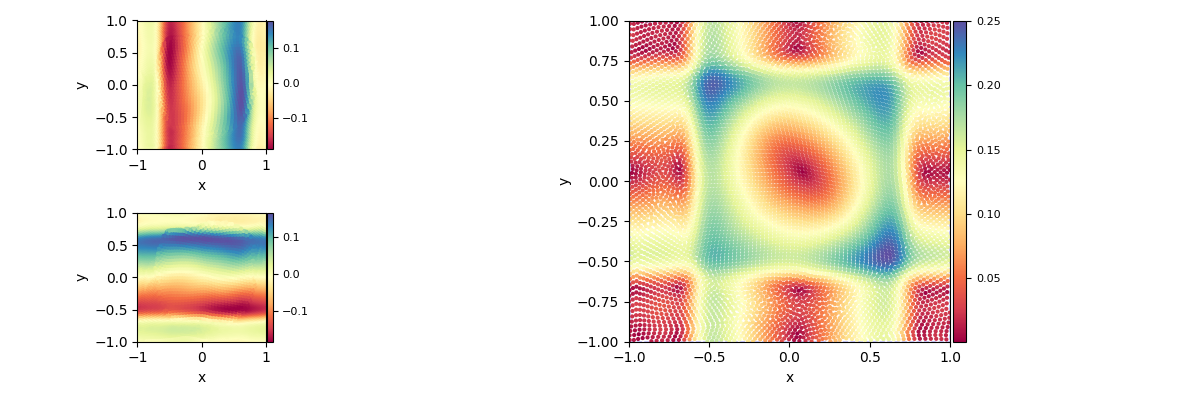

In [225]:
import matplotlib.gridspec as gridspec
# fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

fig, axis = plt.subplot_mosaic('''ABB
                               CBB''', figsize=(12,4), sharex = False, sharey = False)

state = perennialState

visualizeParticles(fig, axis['A'], state['fluidPositions'], state['fluidVelocities'], config['domain']['periodicity'], config['domain']['minExtent'], config['domain']['maxExtent'], mapping = '.x', cbar = True, cmap = visualization['cmap'], scaling = visualization['norm'])
visualizeParticles(fig, axis['C'], state['fluidPositions'], state['fluidVelocities'], config['domain']['periodicity'], config['domain']['minExtent'], config['domain']['maxExtent'], mapping = '.y', cbar = True, cmap = visualization['cmap'], scaling = visualization['norm'])
visualizeParticles(fig, axis['B'], state['fluidPositions'], state['fluidVelocities'], config['domain']['periodicity'], config['domain']['minExtent'], config['domain']['maxExtent'], mapping = 'L2', cbar = True, cmap = visualization['cmap'], scaling = visualization['norm'])


# axis = []
# plot(fig, axis, gs[0,0], visualization, perennialState, config)
# plot(fig, axis, gs[0,0], velocityVisualization, perennialState, config)

# axis = []
# axis.append(fig.add_subplot(gs[0, 0]))
# axis.append(fig.add_subplot(gs[0, 1]))
# axis.append(fig.add_subplot(gs[0, 2]))


# def format_axes(fig):
    # for i, ax in enumerate(fig.axes):
        # ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        # ax.tick_params(labelbottom=False, labelleft=False)
# format_axes(fig)

fig.tight_layout()

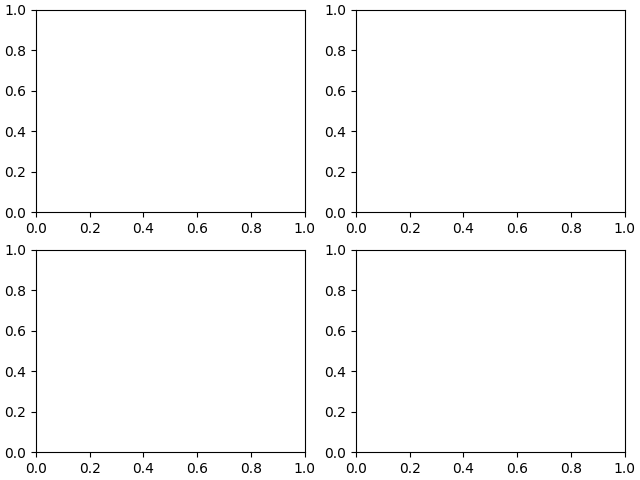

In [160]:
fig2 = plt.figure(constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[0, 1])
f2_ax3 = fig2.add_subplot(spec2[1, 0])
f2_ax4 = fig2.add_subplot(spec2[1, 1])

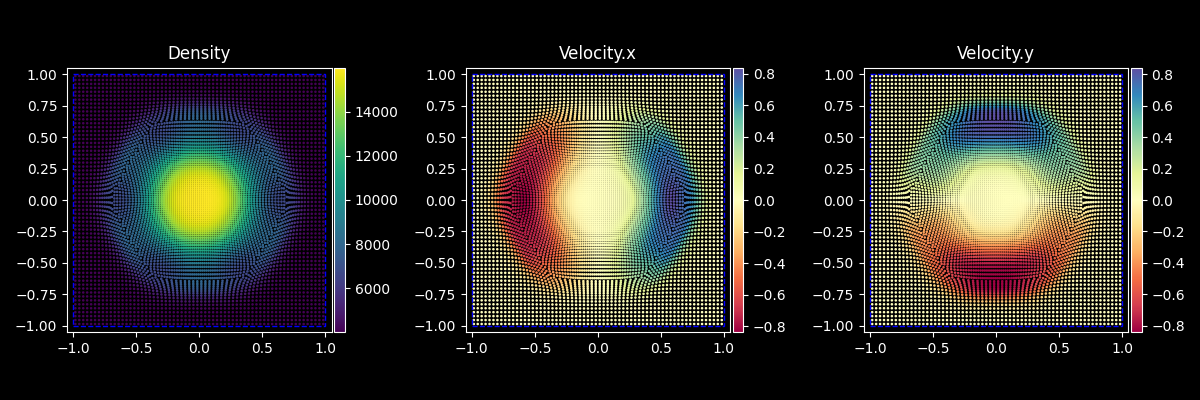

In [42]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')

simulationStates = []


fig, axis, scDensity, cbarDensity, scVelocity_x, cbarVelocity_x, scVelocity_y, cbarVelocity_y = initPlot(perennialState)
updatePlot(perennialState, scDensity, cbarDensity, scVelocity_x, cbarVelocity_x, scVelocity_y, cbarVelocity_y)

In [31]:
p = perennialState['fluidPositions']
periodicPositions = torch.stack([p[:,i] if not periodic else torch.remainder(p[:,i] - config['domain']['minExtent'][i], config['domain']['maxExtent'][i] - config['domain']['minExtent'][i]) + config['domain']['minExtent'][i] for i, periodic in enumerate(config['domain']['periodicity'])], dim = 1)

c = perennialState['fluidDensities']
scDensity.set_offsets(periodicPositions)
scDensity.set_array(c)
scDensity.set_clim(vmin = torch.abs(c).min().item(), vmax = torch.abs(c).max().item())
cbarDensity.update_normal(scDensity)


c = perennialState['fluidVelocities'][:,0]
scVelocity_x.set_offsets(periodicPositions)
scVelocity_x.set_array(perennialState['fluidVelocities'][:,0])
scVelocity_x.set_clim(vmin = torch.abs(c).max().item() * -1, vmax = torch.abs(c).max().item())
cbarVelocity_x.update_normal(scVelocity_x)

c = perennialState['fluidVelocities'][:,1]
scVelocity_y.set_offsets(periodicPositions)
scVelocity_y.set_array(c)
scVelocity_y.set_clim(vmin = torch.abs(c).max().item() * -1, vmax = torch.abs(c).max().item())
cbarVelocity_y.update_normal(scVelocity_y)


In [4]:
import copy
from diffSPH.v2.sampling import samplePDF

def pdf(x):
    x = np.array(x)
    out = np.array(np.ones_like(x))
    out[x > 0] = x[x>0] + 0
    out[x < 0] = x[x<0] + 2
    return out + 1

def pdf(x):
    out = np.array(np.ones_like(x) * 6)
    out[np.abs(x) > 1/3] = 4
    return out

# def pdf(x):
    # return np.ones_like(x)

particles = samplePDF(pdf, n = config['particle']['nx'] * 2, numParticles = config['particle']['nx'], plot = False, randomSampling = False)

In [5]:
# def generateInitialConditions(dim, nx):
#     minDomain = [-1.] * dim
#     maxDomain = [ 1.] * dim
#     # Kernel = getKernel('Wendland2')
#     # nx = 256
#     targetNeighbors = 50
#     dx = (maxDomain [0] - minDomain[0]) / nx
#     vol = dx ** dim
#     h = volumeToSupport(vol, targetNeighbors, dim)

#     print(minDomain, maxDomain)
#     x, _ = sampleRegular(dx, 1, minDomain, maxDomain, targetNeighbors, False, config['kernel']['function'])
#     hx = torch.ones(x.shape[0]) * h
#     areas = torch.ones(x.shape[0]) * vol * 2
#     print(x)
#     mask = ~((x[:,0] >= -0.25) & (x[:,0] <= 0.25)) 
    
#     x = x[mask]
#     hx = hx[mask]
#     areas = areas[mask]

#     x2, _ = sampleRegular(dx / 2, 1, minDomain, maxDomain, targetNeighbors, False, config['kernel']['function'])
#     hx2 = torch.ones(x2.shape[0]) * h
#     areas2 = torch.ones(x2.shape[0]) * vol * 2
#     mask2 = ((x2[:,0] >= -0.25) & (x2[:,0] <= 0.25)) 

#     x = torch.cat((x, x2[mask2]), 0)
#     hx = torch.cat((hx, hx2[mask2]), 0)
#     areas = torch.cat((areas, areas2[mask2]), 0)


#     # areas = areas * (4 + 3 * torch.sin(4 * x[:,0] * np.pi))
#     areas = areas
#     u = torch.zeros_like(x)

#     return x, u, hx, areas, None, minDomain, maxDomain, targetNeighbors, dx
# particles, *_ = generateInitialConditions(1, config['particle']['nx'])
# particles = torch.sort(particles, dim = 0)[0]

In [6]:
perennialState = {}

area = 2 / config['particle']['nx']
perennialState['fluidPositions'] = particles
perennialState['fluidAreas'] = particles.new_ones(particles.shape[0]) * 2 * area
perennialState['fluidMasses'] = perennialState['fluidAreas'] * config['fluid']['rho0']
perennialState['fluidSupports'] = volumeToSupport(area, config['kernel']['targetNeighbors'], config['domain']['dim'])
perennialState['fluidVelocities'] = torch.zeros_like(particles)

perennialState['numParticles'] = particles.shape[0]

perennialState['fluidNeighborhood'] = fluidNeighborSearch(perennialState, config)
perennialState['fluidDensities'] = sphOperationFluidState(perennialState, None, 'density')
_, perennialState['fluidNumNeighbors'] = countUniqueEntries(perennialState['fluidNeighborhood']['indices'][0], perennialState['fluidPositions'])

initialState = copy.deepcopy(perennialState)

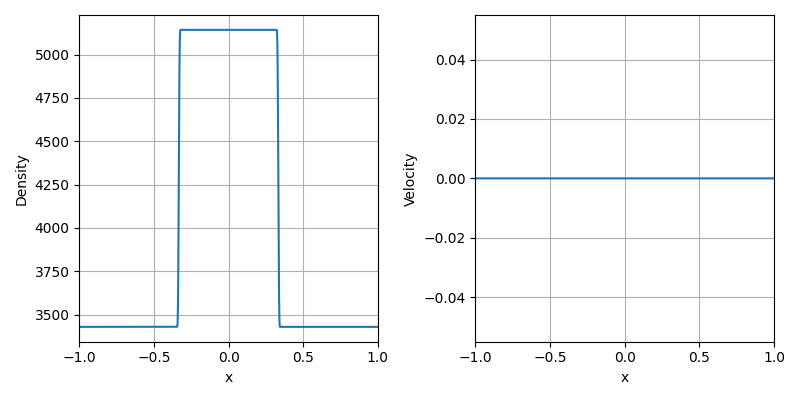

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

perennialState = copy.deepcopy(initialState)
        
fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)


xx, rhox = resampleToGrid1D(perennialState, perennialState['fluidDensities'], config, config['particle']['nx'])
xx, ux   = resampleToGrid1D(perennialState, perennialState['fluidVelocities'], config, config['particle']['nx'])

axis[0,0].plot(xx, rhox)
axis[0,1].plot(xx, ux)
for xax in axis:
    for ax in xax:
        # ax.set_title('Density')
        ax.set_xlabel('x')
        # ax.set_ylabel('Density')
        ax.set_xlim(-1, 1)
        ax.grid(True)
        # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)

axis[0,0].set_ylabel('Density')
axis[0,1].set_ylabel('Velocity')
# scatterPlot(fig, axis[0,0], simulationState, simulationState['fluidNumNeighbors'], 'Number of Neighbors[ni]')

# rho = sphOperation((areas, areas), (ones, ones), (ones, ones), (i, j), Wij, gradWij, xij, rij, hij, particles.shape[0], operation = 'interpolate')
# # print(rho)

# scatterPlot(fig, axis[0,1], simulationState, simulationState['fluidDensities'], '$\\rho$')

fig.tight_layout()

In [8]:
from diffSPH.v2.modules.pressureEOS import computeEOS
from diffSPH.v2.modules.pressureForce import computePressureAccel
from diffSPH.v2.modules.viscosity import computeViscosityMonaghan


# def fluidNeighborSearch(simulationState: dict, config: dict):
#     i, j, rij, xij, hij, Wij, gradWij = neighborSearch(simulationState['fluidPositions'], simulationState['fluidPositions'], simulationState['fluidSupports'], simulationState['fluidSupports'], kernel = config['kernel']['function'], dim = config['domain']['dim'], periodic = config['domain']['periodicity'], minDomain = config['domain']['minExtent'], maxDomain = config['domain']['maxExtent'], algorithm = 'small')
#     neighborDict = {
#         'indices': (i, j),
#         'distances': rij,
#         'vectors': xij,
#         'supports': hij,
#         'kernels': Wij,
#         'gradients': gradWij,
#     }
#     return neighborDict


def simulationStep(simulationState, config):
    simulationState['fluidNeighborhood'] = fluidNeighborSearch(simulationState, config)
    simulationState['fluidDensities'] = sphOperationFluidState(simulationState, None, 'density')

    simulationState['fluidPressures'] = computeEOS(simulationState, config)
    # simulationState['fluidPressures'] = 1.5 * (simulationState['fluidDensities'] - config['fluid']['rho0'])
    simulationState['fluidPressureAccel'] = computePressureAccel(simulationState, config) #sphOperationFluidState(simulationState, (simulationState['fluidPressures'], simulationState['fluidPressures']), operation = 'gradient', gradientMode='symmetric') / simulationState['fluidDensities'].view(-1,1) #computePressureForce(simulationState, config)
    simulationState['fluidViscosityAccel'] = computeViscosityMonaghan(simulationState, config)

    dudt = simulationState['fluidPressureAccel'] + simulationState['fluidViscosityAccel']# * simulationState['fluidDensities'].view(-1,1)

    
    # for j in range(16):
        # print(f'[{j}] {simulationState["fluidVelocities"][j]} {simulationState["fluidPositions"][j]} {simulationState["fluidPressureForces"][j]} {simulationState["fluidViscosityForces"][j]} {dudt[j]}')


    return dudt

In [9]:
# def integrate(perennialState, config, previousStep, simulationStep, scheme = 'semiImplicitEuler'):
#     dt = config['integration']['dt']

#     if scheme == 'semiImplicitEuler':
#         dudt = simulationStep(perennialState, config)
#         perennialState['fluidVelocities'] += dudt * dt
#         perennialState['fluidPositions'] += perennialState['fluidVelocities'] * dt
#     elif scheme == 'explicitEuler':
#         dudt = simulationStep(perennialState, config)
#         perennialState['fluidPositions'] += perennialState['fluidVelocities'] * dt
#         perennialState['fluidVelocities'] += dudt * dt
#     elif scheme == 'verlet':
#         if previousStep is None:
#             previousStep = simulationStep(perennialState, config)
        
#         perennialState['fluidPositions'] += perennialState['fluidVelocities'] * dt + 0.5 * previousStep * dt ** 2
#         dudt = simulationStep(perennialState, config)
#         perennialState['fluidVelocities'] += 0.5 * (dudt + previousStep) * dt
#     elif scheme == 'leapfrog':
#         if previousStep is None:
#             previousStep = simulationStep(perennialState, config)

#         # Compute the new velocity at t + dt/2
#         perennialState['fluidVelocities'] += 0.5 * previousStep * dt

#         # Compute the new position at t + dt
#         perennialState['fluidPositions'] += perennialState['fluidVelocities'] * dt

#         # Compute the new acceleration at t + dt
#         dudt = simulationStep(perennialState, config)

#         # Compute the new velocity at t + dt
#         perennialState['fluidVelocities'] += 0.5 * dudt * dt
#     elif scheme == 'RK4':
#         # Compute k1
#         k1 = simulationStep(perennialState, config)
#         tempState = copy.deepcopy(perennialState)
#         tempState['fluidVelocities'] += k1 * dt / 2
#         tempState['fluidPositions'] += perennialState['fluidVelocities'] * dt / 2

#         # Compute k2
#         k2 = simulationStep(tempState, config)
#         tempState = copy.deepcopy(perennialState)
#         tempState['fluidVelocities'] += k2 * dt / 2
#         tempState['fluidPositions'] += (perennialState['fluidVelocities'] + k1 * dt / 2) * dt / 2

#         # Compute k3
#         k3 = simulationStep(tempState, config)
#         tempState = copy.deepcopy(perennialState)
#         tempState['fluidVelocities'] += k3 * dt
#         tempState['fluidPositions'] += (perennialState['fluidVelocities'] + k2 * dt / 2) * dt

#         # Compute k4
#         k4 = simulationStep(tempState, config)

#         # Update the position and velocity
#         perennialState['fluidPositions'] += dt * (perennialState['fluidVelocities'] + (k1 + 2*k2 + 2*k3 + k4) * dt / 6)
#         perennialState['fluidVelocities'] += (k1 + 2*k2 + 2*k3 + k4) * dt / 6
#         dudt = (k1 + 2*k2 + 2*k3 + k4) * dt / 6
#     return perennialState, dudt

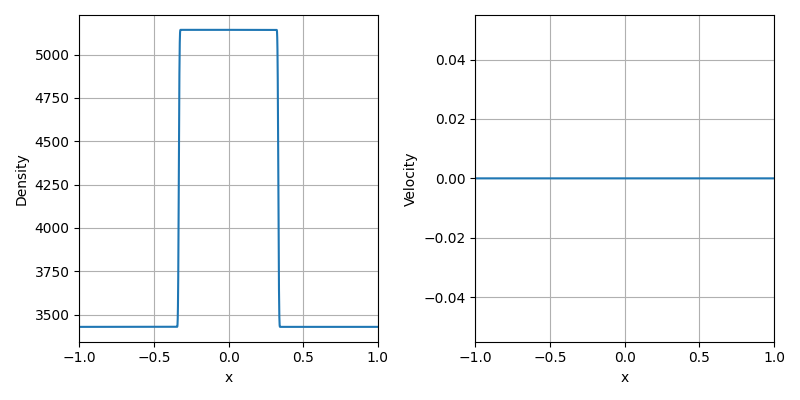

In [10]:
simulationState = {}

config['integration']['dt'] = 0.001
config['fluid']['mu'] = 0.001

perennialState = copy.deepcopy(initialState)

perennialState['numParticles'] = perennialState['fluidPositions'].shape[0]

perennialState['fluidNeighborhood'] = fluidNeighborSearch(perennialState, config)
perennialState['fluidDensities'] = sphOperationFluidState(perennialState, None, 'density')
_, perennialState['fluidNumNeighbors'] = countUniqueEntries(perennialState['fluidNeighborhood']['indices'][0], perennialState['fluidPositions'])



xx, rhox = resampleToGrid1D(perennialState, perennialState['fluidDensities'], config, config['particle']['nx'])
xx, ux   = resampleToGrid1D(perennialState, perennialState['fluidVelocities'], config, config['particle']['nx'])


fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)

axis[0,0].plot(xx, rhox)
axis[0,1].plot(xx, ux)
for xax in axis:
    for ax in xax:
        # ax.set_title('Density')
        ax.set_xlabel('x')
        # ax.set_ylabel('Density')
        ax.set_xlim(-1, 1)
        ax.grid(True)
        # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)

axis[0,0].set_ylabel('Density')
axis[0,1].set_ylabel('Velocity')

fig.tight_layout()
fig.canvas.draw()
fig.canvas.flush_events()

simulationStates = []

In [11]:
from tqdm.autonotebook import tqdm
import copy

dudt = None

import matplotlib.pyplot as plt
import matplotlib.colors as colors

norm = colors.Normalize(vmin=0, vmax=2048)
cmap = plt.cm.get_cmap('viridis')

# Use the colormap to get colors based on the norm
# color = cmap(norm)

for i in tqdm(range(2048)):
    perennialState, dudt = integrate(simulationStep, perennialState, config, previousStep= dudt)

    # dudt = simulationStep(simulationState, config)
    simulationStates.append(copy.deepcopy(perennialState))
    # simulationState['fluidVelocities'] += dudt * config['integration']['dt']
    # simulationState['fluidPositions'] += simulationState['fluidVelocities'] * config['integration']['dt']

    if i % 16 == 0:
        xx, rhox = resampleToGrid1D(perennialState, perennialState['fluidDensities'], config, config['particle']['nx'])
        xx, ux   = resampleToGrid1D(perennialState, perennialState['fluidVelocities'], config, config['particle']['nx'])

        axis[0,0].lines[0].remove()
        axis[0,1].lines[0].remove()

        axis[0,0].plot(xx, rhox, c = cmap(norm(i)))
        axis[0,1].plot(xx, ux, c = cmap(norm(i)))
        
        fig.canvas.draw()
        fig.canvas.flush_events()
    # break

  0%|          | 0/2048 [00:00<?, ?it/s]

In [16]:
config['neighborhood']['scheme'] = 'small'

In [17]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=False, profile_memory=True) as prof:    
    for i in range(32):
        with record_function("numpy"): 
           simulationStep(perennialState, config)
        
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))

prof.export_chrome_trace("traceGPU.json")

STAGE:2024-02-20 16:43:21 4835:4835 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2024-02-20 16:43:22 4835:4835 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2024-02-20 16:43:22 4835:4835 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


-----------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                     Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-----------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                    numpy         0.46%       3.870ms       100.00%     836.539ms      26.142ms           0 b    -239.27 Mb            32  
                           NeighborSearch         0.33%       2.790ms        82.25%     688.036ms      21.501ms     236.77 Mb           0 b            32  
            NeighborSearch [radiusSearch]        73.19%     612.288ms        74.33%     621.787ms      19.431ms     104.79 Mb      -4.95 Mb            32  
                             sphOperation         0.43%       3.

In [16]:
# %timeit torch.linalg.norm(v, dim = -1, ord = 2)
# %timeit np.linalg.norm(v.numpy(), axis = -1)
# %timeit (v[:,0] ** 2) ** 0.5

9.31 ms ± 6.34 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
69.6 µs ± 132 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
32.2 µs ± 189 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [45]:
# torch.norm(v, dim = -1, p = 2)
# (v[:,0] ** 2) ** 0.5
# v.shape

torch.Size([81274, 1])

In [47]:
# x = torch.randn(81274, 1)
# y = torch.randn(81274, 1)
# %timeit torch.sqrt((x - y).pow(2).sum(1))
# %timeit torch.norm(x - y, 2, 1)
# x = x.cuda()
# y = y.cuda()
# %timeit torch.sqrt((x - y).pow(2).sum(1))
# %timeit torch.norm(x - y, 2, 1)

90 µs ± 5.66 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
5.58 ms ± 196 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


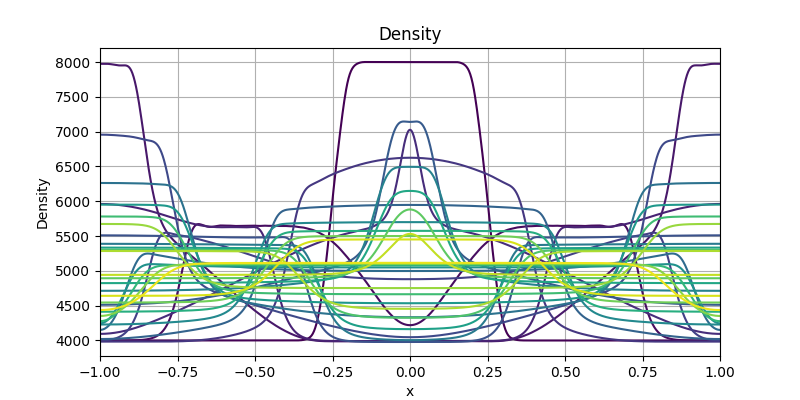

In [41]:
xx, rhox = resampleToGrid1D(perennialState, simulationStates[i]['fluidDensities'], config, config['particle']['nx'])
fig, axis = plt.subplots(1, 1, figsize=(8,4), sharex = True, sharey = True, squeeze = False)

import matplotlib.cm as cm
import matplotlib.colors as colors

cmap = cm.get_cmap('viridis')
norm = colors.Normalize(vmin=0, vmax=len(simulationStates) * config['integration']['dt'])


for i in range(1, len(simulationStates), 32):
    xx, rhox = resampleToGrid1D(simulationStates[i], simulationStates[i]['fluidDensities'], config, config['particle']['nx'])
    axis[0,0].plot(xx, rhox, label = 't = {}'.format(i * config['integration']['dt']), c = cmap(norm(i * config['integration']['dt'])))

# axis[0,0].plot(xx, rhox)
axis[0,0].set_title('Density')
axis[0,0].set_xlabel('x')
axis[0,0].set_ylabel('Density')
axis[0,0].set_xlim(-1, 1)
axis[0,0].grid(True)
axis[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
axis[0,0].set_title('Density')
axis[0,0].set_xlabel('x')
axis[0,0].set_ylabel('Density')
axis[0,0].set_xlim(-1, 1)
axis[0,0].grid(True)

fig.tight_layout()

torch.Size([1024, 1]) torch.Size([1024])
torch.Size([1024, 1025]) torch.Size([1024, 1025]) torch.Size([1024, 1025])


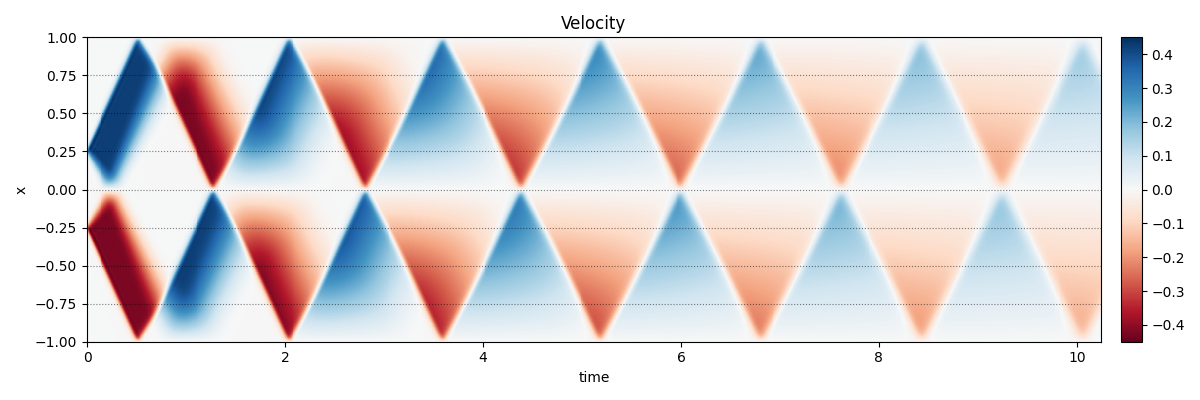

In [42]:
gridData = [
    resampleToGrid1D(simulationStates[i], simulationStates[i]['fluidVelocities'][:,0], config, config['particle']['nx']) for i in range(len(simulationStates))]
print(gridData[0][0].shape, gridData[0][1].shape)

xxs = torch.stack([x[:,0] for x, rho in gridData], dim=1)
rhos = torch.stack([rho for x, rho in gridData], dim=1)
ts = torch.stack([torch.ones(xxs.shape[0])* i * config['integration']['dt'] for i in range(len(simulationStates))], dim=1)
print(xxs.shape, rhos.shape, ts.shape)


fig, axis = plt.subplots(1, 1, figsize=(12,4), sharex = True, sharey = True, squeeze = False)
# im = axis[0,0].scatter(xxs, ts, c = rhos, s = 1)

im = axis[0,0].pcolormesh(ts.mT.numpy(), xxs.mT.numpy(), rhos.mT.numpy(), cmap = 'RdBu')
axis[0,0].set_title('Velocity')
axis[0,0].set_ylabel('x')
axis[0,0].set_xlabel('time')
axis[0,0].set_ylim(-1, 1)
axis[0,0].grid(axis = 'y', ls = ':', alpha = 0.5, c = 'black')
# axis[0,0].set_xscale('log')

divider = make_axes_locatable(axis[0,0])
cax = divider.append_axes("right", size="2%", pad='2%')
fig.colorbar(im, cax=cax, orientation='vertical')
fig.tight_layout()


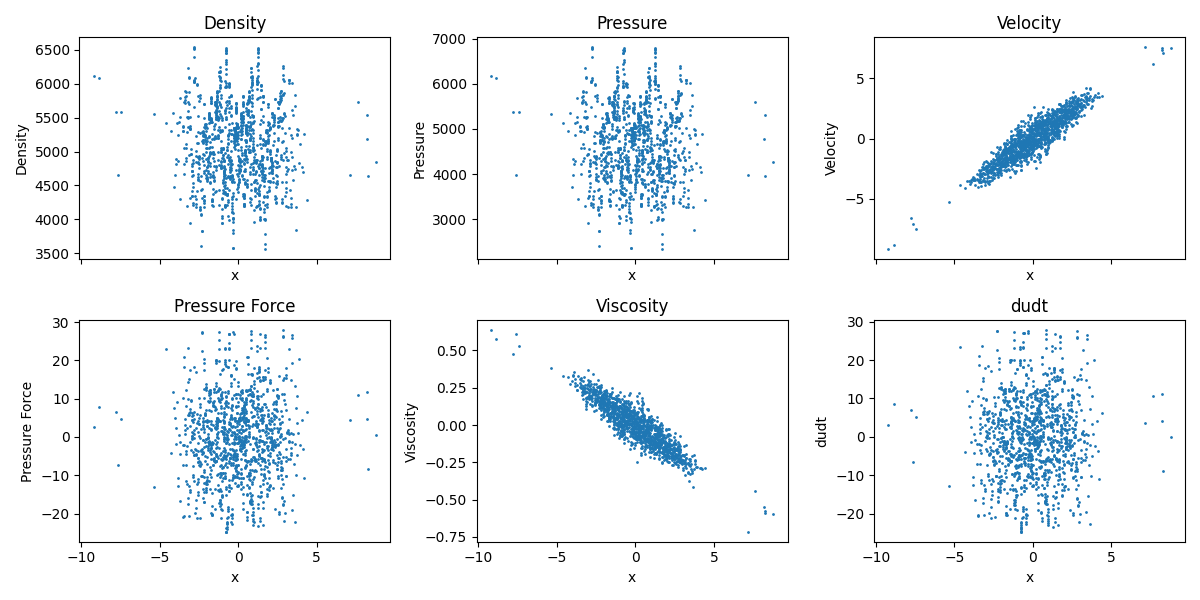

In [23]:

fig, axis = plt.subplots(2, 3, figsize=(12,6), sharex = True, sharey = False, squeeze = False)

axis[0,0].scatter(particles[:,0], simulationState['fluidDensities'], s = 1)
axis[0,0].set_title('Density')  
axis[0,0].set_xlabel('x')
axis[0,0].set_ylabel('Density')

axis[0,1].scatter(particles[:,0], simulationState['fluidPressures'], s = 1)
axis[0,1].set_title('Pressure')
axis[0,1].set_xlabel('x')
axis[0,1].set_ylabel('Pressure')

axis[0,2].scatter(particles[:,0], simulationState['fluidVelocities'][:,0], s = 1)
axis[0,2].set_title('Velocity')
axis[0,2].set_xlabel('x')
axis[0,2].set_ylabel('Velocity')

axis[1,0].scatter(particles[:,0], simulationState['fluidPressureForces'], s = 1)
axis[1,0].set_title('Pressure Force')
axis[1,0].set_xlabel('x')
axis[1,0].set_ylabel('Pressure Force')

axis[1,1].scatter(particles[:,0], simulationState['fluidViscosityForces'], s = 1)
axis[1,1].set_title('Viscosity')
axis[1,1].set_xlabel('x')
axis[1,1].set_ylabel('Viscosity')

axis[1,2].scatter(particles[:,0], dudt, s = 1)
axis[1,2].set_title('dudt')
axis[1,2].set_xlabel('x')
axis[1,2].set_ylabel('dudt')

# simulationState['rho']
fig.tight_layout()

In [17]:
particles.shape

torch.Size([1280, 1])

In [40]:
simulationState['fluidMasses'][0].item() / 2000
torch.float32

torch.float32

In [41]:

simulationState['fluidNeighborhood'] = fluidNeighborSearch(simulationState, config)
simulationState['fluidDensities'] = sphOperationFluidState(simulationState, None, 'density')
_, simulationState['fluidNumNeighbors'] = countUniqueEntries(simulationState['fluidNeighborhood']['indices'][0], simulationState['fluidPositions'])


In [42]:
simulationState['fluidNumNeighbors']

tensor([49, 49, 49,  ..., 49, 49, 49])

In [43]:
simulationState['fluidNeighborhood']

{'indices': (tensor([   0,    0,    0,  ..., 1023, 1023, 1023]),
  tensor([1012, 1013, 1014,  ...,    9,   10,   11])),
 'distances': tensor([0.4800, 0.4400, 0.4000,  ..., 0.4000, 0.4400, 0.4800]),
 'vectors': tensor([[-1.],
         [-1.],
         [-1.],
         ...,
         [ 1.],
         [ 1.],
         [ 1.]]),
 'supports': tensor([0.0488, 0.0488, 0.0488,  ..., 0.0488, 0.0488, 0.0488]),
 'kernels': tensor([ 8.7829, 10.4302, 12.1651,  ..., 12.1651, 10.4302,  8.7829]),
 'gradients': tensor([[ 816.5806],
         [ 868.1202],
         [ 905.9698],
         ...,
         [-905.9698],
         [-868.1202],
         [-816.5806]])}

Text(0.5, 1.0, 'Kernels')

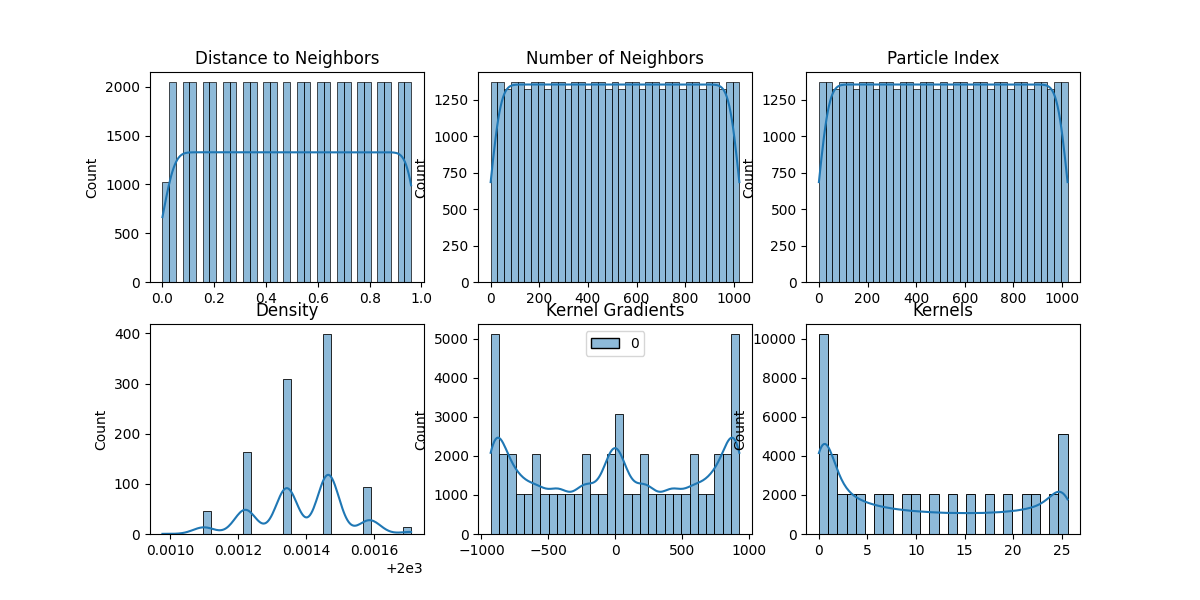

In [44]:
import seaborn as sns



fig, axis = plt.subplots(2, 3, figsize=(12,6), sharex = False, sharey = False, squeeze = False)
sns.histplot(simulationState['fluidNeighborhood']['distances'], kde=True, ax = axis[0,0])
axis[0,0].set_title('Distance to Neighbors')
sns.histplot(simulationState['fluidNeighborhood']['indices'][1], kde=True, ax = axis[0,1])
axis[0,1].set_title('Number of Neighbors')
sns.histplot(simulationState['fluidNeighborhood']['indices'][0], kde=True, ax = axis[0,2])
axis[0,2].set_title('Particle Index')

sns.histplot(simulationState['fluidDensities'], kde=True, ax = axis[1,0])
axis[1,0].set_title('Density')


sns.histplot(simulationState['fluidNeighborhood']['gradients'], kde=True, ax = axis[1,1])
axis[1,1].set_title('Kernel Gradients')

sns.histplot(simulationState['fluidNeighborhood']['kernels'], kde=True, ax = axis[1,2])
axis[1,2].set_title('Kernels')
